#### Preprocessing Charging Sessions Dataset

First, we import important libraries needed for the following tasks.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

We import the necessary dataset (charging sessions of EVs) with the data of charging garages in Los Angeles.

In [2]:
data_raw = pd.read_csv("data/charging_sessions.csv")

Getting a first sight of the data by displaying the first 5 observations.

In [3]:
data_raw.head(5)

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [4]:
num_rows, num_columns = data_raw.shape
print(f"rows: {num_rows}, columns: {num_columns}")

rows: 66450, columns: 13


The data in the dataset contains 66.450 observation over 13 different variables. Next, we drop duplicates and have closer look at the different datatypes.

In [5]:
columns = [
    'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered',
    'sessionID', 'siteID', 'spaceID', 'stationID', 'timezone', 'userID', 'userInputs'
]
data_unique = data_raw.drop_duplicates(subset=columns)

In [6]:
dtypes_data = data_unique.dtypes.reset_index()
dtypes_data.columns = ['Row', 'Datetype']
print(dtypes_data)

                 Row Datetype
0         Unnamed: 0    int64
1                 id   object
2     connectionTime   object
3     disconnectTime   object
4   doneChargingTime   object
5       kWhDelivered  float64
6          sessionID   object
7             siteID    int64
8            spaceID   object
9          stationID   object
10          timezone   object
11            userID  float64
12        userInputs   object


We convert all the data into corresponding data types so that we can use them in the further analysis. 
The time-related data is given in the UTC time zone, but the garages are in Los Angeles. In order to obtain accurate information about the timestamps, the data must therefore be converted to the corresponding time zone (LosAngeles).  

In [7]:
data_unique['id'] = data_unique['id'].astype("string")
data_unique['connectionTime'] = pd.to_datetime(data_unique['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['disconnectTime'] = pd.to_datetime(data_unique['disconnectTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['doneChargingTime'] = pd.to_datetime(data_unique['doneChargingTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['siteID'] = data_unique['siteID'].astype("int")
data_unique['spaceID'] = data_unique['spaceID'].astype("string")
data_unique['stationID'] = data_unique['stationID'].astype("string")
data_unique['timezone'] = data_unique['timezone'].astype("string")
data_unique['userID'] = data_unique['userID'].astype("string")
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['userInputs'] = data_unique['userInputs'].apply(lambda x: list(x) if isinstance(x, list) else [x])

The `unnamed` column is presumably an index from the riginal DataFrame and gets transferred into a column when reading the CSV-file. Since our data contains a unique ID for each entry, the unnamed-numbering is not needed and can be deleted.

In [8]:
data_unique = data_unique.drop('Unnamed: 0', axis=1)

print(data_unique.dtypes)

id                  string[python]
connectionTime      datetime64[ns]
disconnectTime      datetime64[ns]
doneChargingTime    datetime64[ns]
kWhDelivered               float64
sessionID           string[python]
siteID                       int32
spaceID             string[python]
stationID           string[python]
timezone            string[python]
userID              string[python]
userInputs                  object
dtype: object


In [9]:
print(data_unique.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 65036
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                65037 non-null  string        
 1   connectionTime    65037 non-null  datetime64[ns]
 2   disconnectTime    65037 non-null  datetime64[ns]
 3   doneChargingTime  60950 non-null  datetime64[ns]
 4   kWhDelivered      65037 non-null  float64       
 5   sessionID         65037 non-null  string        
 6   siteID            65037 non-null  int32         
 7   spaceID           65037 non-null  string        
 8   stationID         65037 non-null  string        
 9   timezone          65037 non-null  string        
 10  userID            47822 non-null  string        
 11  userInputs        65037 non-null  object        
dtypes: datetime64[ns](3), float64(1), int32(1), object(1), string(6)
memory usage: 6.2+ MB
None


In [10]:
missing_values_count = data_unique.isnull().sum()
print(missing_values_count)

id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4087
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17215
userInputs              0
dtype: int64


By looking at the dataframe, you can see that `doneChargingTime` and `userID` have missing values.  

The missing values in userID can be explained by the fact that not every garage user is registered; therefore, some accounts are naturally absent. However, the missing entries in `doneChargingTime` appear unusual.

In [11]:
# create Table with missing values in doneChargingTimeb
miss_doneChargingTime = data_unique[data_unique['doneChargingTime'].isna()]
miss_doneChargingTime.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
3756,5ea3848df9af8b428bf97225,2020-04-08 09:36:53,2020-04-08 20:43:29,NaT,25.183,1_1_194_822_2020-04-08 16:36:53.316264,1,AG-1F12,1-1-194-822,America/Los_Angeles,507.0,"[[{'WhPerMile': 250, 'kWhRequested': 75.0, 'mi..."
3757,5ea4d60df9af8b46573f1ee7,2020-04-09 06:23:52,2020-04-09 10:59:02,NaT,14.136,1_1_193_827_2020-04-09 13:23:51.689520,1,AG-1F02,1-1-193-827,America/Los_Angeles,419.0,"[[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mi..."
3758,5ea4d60df9af8b46573f1ee8,2020-04-09 06:40:03,2020-04-09 14:43:22,NaT,14.203,1_1_178_823_2020-04-09 13:39:55.115497,1,AG-1F08,1-1-178-823,America/Los_Angeles,5065.0,"[[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mi..."
3759,5ea4d60df9af8b46573f1ee9,2020-04-09 07:01:53,2020-04-09 09:33:40,NaT,13.041,1_1_178_828_2020-04-09 14:01:53.467693,1,AG-1F10,1-1-178-828,America/Los_Angeles,651.0,"[[{'WhPerMile': 400, 'kWhRequested': 20.0, 'mi..."
3760,5ea4d60df9af8b46573f1eea,2020-04-09 08:01:06,2020-04-09 16:38:08,NaT,5.797,1_1_193_820_2020-04-09 15:01:06.343454,1,AG-1F04,1-1-193-820,America/Los_Angeles,466.0,"[[{'WhPerMile': 300, 'kWhRequested': 6.0, 'mil..."


Upon closer analysis of the missing entries for the charging time (`miss_doneChargingTime`), we found that all of them have normal values for the attribute `kWhDelivered`, indicating that current flow was indeed present.

(Removing this data from the dataframe would imply that the charging stations were free at those times, which is inaccurate and would skew predictions. Therefore, we decided to retain this data for now and, if necessary, exclude it during model training and predictions about parking space utilization after charging is complete.)

We calculate the the percentage of missing (NaN) values for each column.

In [12]:
data_unique.isnull().mean() * 100

id                   0.000000
connectionTime       0.000000
disconnectTime       0.000000
doneChargingTime     6.284115
kWhDelivered         0.000000
sessionID            0.000000
siteID               0.000000
spaceID              0.000000
stationID            0.000000
timezone             0.000000
userID              26.469548
userInputs           0.000000
dtype: float64

Let's calculate the percentage of data left after removing the missing values.

In [13]:
len(data_unique['doneChargingTime'].dropna())/len(data_unique['doneChargingTime']) * 100

93.71588480403462

After removing the columns with missing values, around 94% of the data is still intact which seems to be sufficient. So we first create a copy of the data set in order to then remove the missing values from ‘doneChargingTime’.

In [14]:
# Create a copy of the data before dropping NA values from doneChaargingTime
data_with_NA = data_unique.copy()

# Drop NA from doneChargingTime
data_unique.dropna(subset=['doneChargingTime'], inplace=True)

print(data_unique['doneChargingTime'].isnull().sum())

0


We can explore how the data is distributed in each column before and after removing null values by plotting histograms. This approach will enable us to compare the distribution trends in both scenarios.

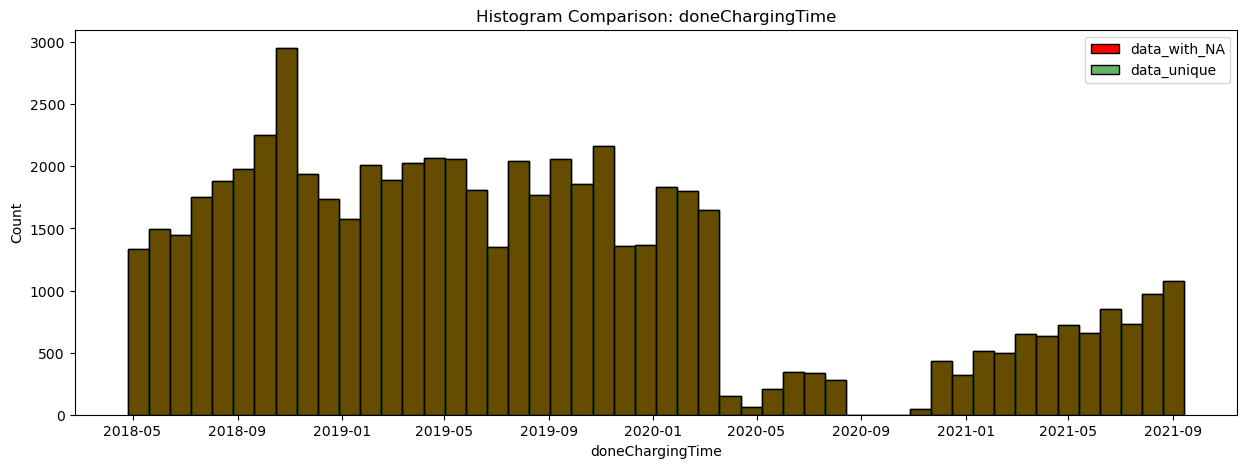

In [15]:
plt.figure(figsize=(15, 5))

# Histogram: Data with doneChargingTime NaT values
sns.histplot(data=data_with_NA, x='doneChargingTime', bins=50, color='red', alpha=1, kde=False, label='data_with_NA')

# Histogram: Data with removed doneChargingTime NaT values
sns.histplot(data=data_unique, x='doneChargingTime', bins=50, color='green', alpha=0.6, kde=False, label='data_unique')

plt.legend()

plt.title('Histogram Comparison: doneChargingTime')
plt.xlabel('doneChargingTime')
plt.ylabel('Count')

plt.show()


By comparing the histograms of the 'doneChargingTime' column before and after removing the null values, it is clear that the data distribution stays consistent. The overlapping histograms show that there is no major change in the distribution pattern after null values were removed.

In [16]:
filtered_data = data_unique[data_unique['doneChargingTime'] > data_unique['disconnectTime']]

filtered_data['time_difference'] = (filtered_data['doneChargingTime'] - filtered_data['disconnectTime']).dt.total_seconds()

average_difference = filtered_data['time_difference'].mean()

average_kwh_delivered = filtered_data['kWhDelivered'].mean()

other_cases = data_unique[data_unique['doneChargingTime'] <= data_unique['disconnectTime']]

average_kwh_delivered_other = other_cases['kWhDelivered'].mean()

print(f"Average Difference: {average_difference:.2f} seconds")
print(f"Average kWh (doneChargingTime > disconnectTime): {average_kwh_delivered:.2f} kWh")
print(f"Average kWh (doneChargingTime <= disconnectTime): {average_kwh_delivered_other:.2f} kWh")

Average Difference: 56.02 seconds
Average kWh (doneChargingTime > disconnectTime): 14.24 kWh
Average kWh (doneChargingTime <= disconnectTime): 11.38 kWh


In [17]:
filtered_data.head(10)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,time_difference
12,5e23b149f9af8b5fe4b973db,2020-01-02 07:04:38,2020-01-02 14:08:39,2020-01-02 14:09:36,25.567,1_1_178_824_2020-01-02 15:04:38.051735,1,AG-1F07,1-1-178-824,America/Los_Angeles,528.0,"[[{'WhPerMile': 250, 'kWhRequested': 50.0, 'mi...",57.0
20,5e23b149f9af8b5fe4b973e3,2020-01-02 07:28:47,2020-01-02 11:01:54,2020-01-02 11:02:51,7.417,1_1_193_827_2020-01-02 15:28:46.685366,1,AG-1F02,1-1-193-827,America/Los_Angeles,1283.0,"[[{'WhPerMile': 350, 'kWhRequested': 42.0, 'mi...",57.0
25,5e23b149f9af8b5fe4b973e8,2020-01-02 07:42:05,2020-01-02 13:58:45,2020-01-02 13:59:42,36.701,1_1_179_797_2020-01-02 15:42:05.217965,1,AG-3F23,1-1-179-797,America/Los_Angeles,474.0,"[[{'WhPerMile': 400, 'kWhRequested': 32.0, 'mi...",57.0
26,5e23b149f9af8b5fe4b973e9,2020-01-02 07:57:24,2020-01-02 08:35:37,2020-01-02 08:36:34,3.689,1_1_179_781_2020-01-02 15:57:23.951170,1,AG-3F31,1-1-179-781,America/Los_Angeles,724.0,"[[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mil...",57.0
33,5e23b149f9af8b5fe4b973f0,2020-01-02 08:34:35,2020-01-02 10:49:41,2020-01-02 10:50:38,7.120,1_1_179_790_2020-01-02 16:34:34.999200,1,AG-3F19,1-1-179-790,America/Los_Angeles,2276.0,"[[{'WhPerMile': 600, 'kWhRequested': 18.0, 'mi...",57.0
45,5e23b149f9af8b5fe4b973fc,2020-01-02 10:41:22,2020-01-02 11:38:24,2020-01-02 11:39:23,5.430,1_1_191_812_2020-01-02 18:41:22.082480,1,AG-4F46,1-1-191-812,America/Los_Angeles,741.0,"[[{'WhPerMile': 400, 'kWhRequested': 32.0, 'mi...",59.0
49,5e23b149f9af8b5fe4b97400,2020-01-02 11:08:34,2020-01-02 14:52:36,2020-01-02 14:53:36,22.839,1_1_191_811_2020-01-02 19:08:34.209436,1,AG-4F42,1-1-191-811,America/Los_Angeles,1283.0,"[[{'WhPerMile': 350, 'kWhRequested': 42.0, 'mi...",60.0
51,5e23b149f9af8b5fe4b97402,2020-01-02 11:30:53,2020-01-02 15:18:39,2020-01-02 15:19:36,4.405,1_1_179_810_2020-01-02 19:30:53.010234,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[[{'WhPerMile': 250, 'kWhRequested': 10.0, 'mi...",57.0
53,5e23b149f9af8b5fe4b97404,2020-01-02 12:31:37,2020-01-02 18:21:37,2020-01-02 18:22:34,33.645,1_1_178_823_2020-01-02 20:31:37.206013,1,AG-1F08,1-1-178-823,America/Los_Angeles,337.0,"[[{'WhPerMile': 250, 'kWhRequested': 35.0, 'mi...",57.0
57,5e23b149f9af8b5fe4b97408,2020-01-02 14:46:56,2020-01-02 16:49:34,2020-01-02 16:50:34,13.005,1_1_179_809_2020-01-02 22:46:56.495691,1,AG-3F27,1-1-179-809,America/Los_Angeles,2276.0,"[[{'WhPerMile': 600, 'kWhRequested': 18.0, 'mi...",60.0


#### Outlier Detection

This analysis focuses on detecting outliers in the kWhDelivered column. We start by examining the statistical summary to understand the data distribution.

In [18]:
data_unique.describe()[['kWhDelivered']]

,kWhDelivered
count,60950.000000
mean,11.583268
min,0.501000
25%,5.013000
50%,8.991000
75%,13.984000
max,108.797242
std,10.153601


Although the mean is relatively sensitive to outliers, the mean of kWhDelivered is 11.58 while the maximum is 108.8. This shows that the maximum is an outlier. We make use of a boxplot and a histogram to visually summarize the distribution and identify potential outliers.

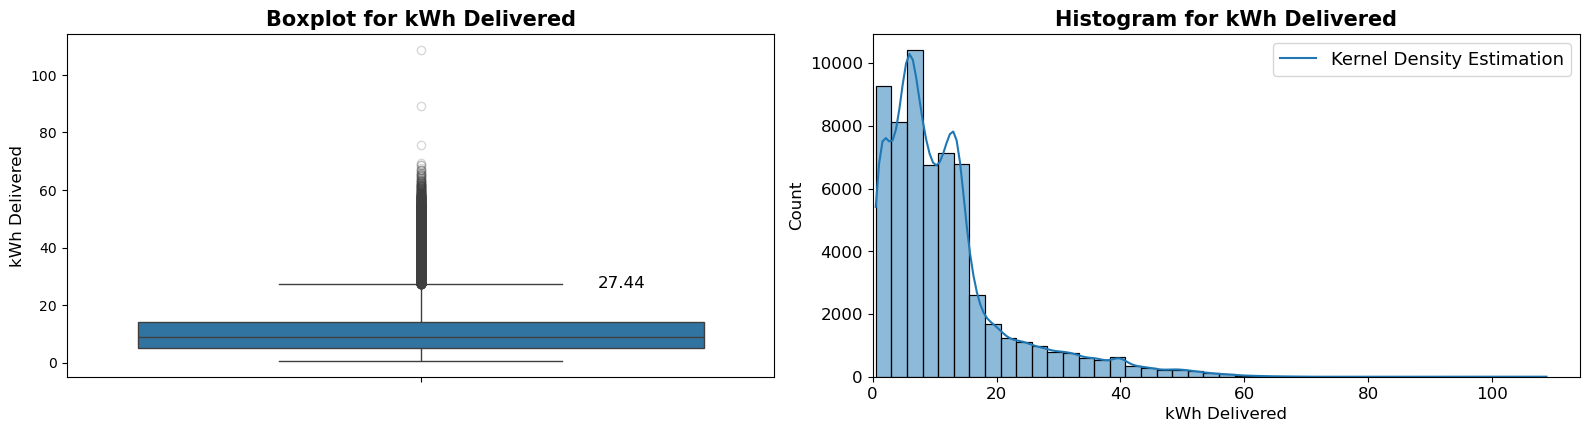

In [19]:
plt.figure(figsize=(16, 8))

q1 = data_unique['kWhDelivered'].quantile(0.25)
q3 = data_unique['kWhDelivered'].quantile(0.75)
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr

# Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data_unique, y='kWhDelivered', flierprops={'alpha': 0.2})
plt.title("Boxplot for kWh Delivered", fontsize=15, fontweight='bold')
plt.ylabel("kWh Delivered", fontsize=12)
plt.xlabel("")
plt.text(0.25, upper_whisker, f"{upper_whisker:.2f}", 
         ha='left', va='center', fontsize=12, color='black')

# Histogram
plt.subplot(2, 2, 2)
sns.histplot(data_unique['kWhDelivered'], kde=True, binwidth=2.5)
plt.title("Histogram for kWh Delivered", fontsize=15, fontweight='bold')
plt.xlabel("kWh Delivered", fontsize=12)
plt.ylabel("Count", fontsize=12) 
plt.legend(labels=["Kernel Density Estimation"], fontsize=13)

plt.xlim(left=0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Based on the two visualizations, it is evident that the majority of the values are quite low. The upper whisker of the boxplot is at 27.44, meaning it represents the largest value in the dataset that is less than or equal to Q3 + 1.5 * IQR. Values above this threshold are considered outliers. These become more frequent up to approximately 60. Only three observations fall between 75 and 110. The distribution is highly positively right skewed.

The following function calculates the IQR to detect outliers above the upper whisker.

In [20]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   iqr=q3-q1

   outliers = df[((df<(q1-1.5*iqr)) | (df>(q3+1.5*iqr)))]

   return outliers

In [21]:
outliers = find_outliers_IQR(data_unique['kWhDelivered'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))

outliers

number of outliers: 5168
max outlier value: 108.79724166666666
min outlier value: 27.442


1        33.097
6        43.477
7        32.441
13       39.806
21       49.874
          ...  
65003    32.334
65005    30.030
65008    35.007
65024    30.198
65029    41.047
Name: kWhDelivered, Length: 5168, dtype: float64

The summary indicates that there are 5,168 outliers. The lowest outlier value is 27.44, as previously mentioned, while the maximum is 108.8.

In [22]:
data_unique[data_unique['kWhDelivered'] > 70]

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
18641,610c829df9af8b0580e98730,2021-07-20 15:16:54,2021-07-21 08:18:03,2021-07-21 08:19:00,108.797242,1_1_193_829_2021-07-20 18:27:33.500144,1,AG-1F03,1-1-193-829,America/Los_Angeles,378.0,"[[{'WhPerMile': 258, 'kWhRequested': 35.088, '..."
18643,610c829df9af8b0580e98732,2021-07-20 15:16:56,2021-07-21 08:18:16,2021-07-21 08:19:13,89.362732,1_1_194_818_2021-07-20 13:54:47.875453,1,AG-1F14,1-1-194-818,America/Los_Angeles,481.0,"[[{'WhPerMile': 360, 'kWhRequested': 86.4, 'mi..."
20986,5c60d02df9af8b149d7da395,2019-01-25 19:40:20,2019-01-26 14:36:03,2019-01-26 06:45:12,75.528000,2_39_91_437_2019-01-26 03:40:20.383123,2,CA-317,2-39-91-437,America/Los_Angeles,1225.0,"[[{'WhPerMile': 600, 'kWhRequested': 180.0, 'm..."


The high kWhDelivered values are rare but appear to be realistic given the long charging durations.

The following function replaces the outlier values that exceed the given upper limit with the median value of 'kWhDelivered'.

In [23]:
def cap_outliers(df, column, upper_limit):

    median = df[column].median()
    print(f"Median: {median}")

    upper_limit = upper_limit
    print(f"Upper limit: {upper_limit}")

    df[column] = np.where(
        df[column] > upper_limit,
        median,
        df[column]
    )
    return df


In [24]:
data_without_outliers = cap_outliers(data_unique, 'kWhDelivered', 27)

Median: 8.991
Upper limit: 27


Replotting the resulting distribution after capping the outliers at 27.

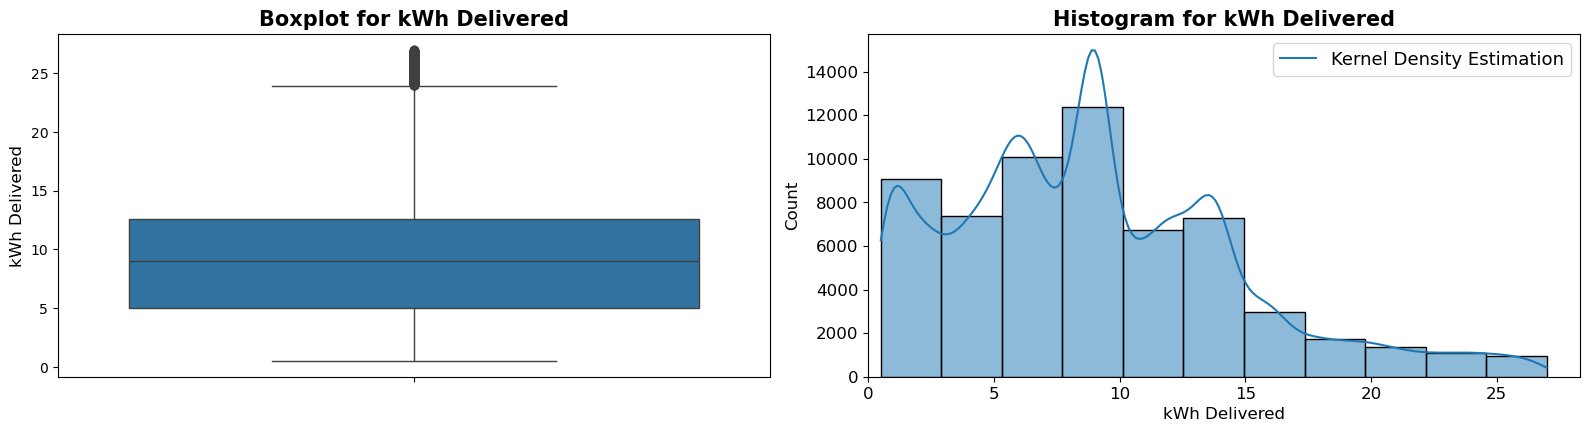

In [25]:
plt.figure(figsize=(16, 8))

# Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=data_without_outliers, y='kWhDelivered', flierprops={'alpha': 0.1})
plt.title("Boxplot for kWh Delivered", fontsize=15, fontweight='bold')
plt.ylabel("kWh Delivered", fontsize=12)
plt.xlabel("") 

# Histogram
plt.subplot(2, 2, 2)
sns.histplot(data_without_outliers['kWhDelivered'], kde=True, binwidth=2.5)
plt.title("Histogram for kWh Delivered", fontsize=15, fontweight='bold')
plt.xlabel("kWh Delivered", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(labels=["Kernel Density Estimation"], fontsize=13)

plt.xlim(left=0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

By capping the outliers at the upper whisker to the median, the distribution becomes more stable and less influenced by extreme values. The values concentrate more closely around the median, making the distribution more compact.

#### Extracting "userInputs" into a Separate Table

Process the column userInputs to ensure each entry is JSON-formatted and interpretable as a Python dictionary.

In [26]:
import json

data_unique['userInputs'] = data_unique['userInputs'].astype("string")

def format_user_input(entry):
    try:
        entry = entry[2:-2]
        entry = entry.replace("'", "\"").replace("True", "true").replace("False", "false")  
        return json.loads(entry)  
    except json.JSONDecodeError:
        return None  


data_unique['userInputs']= data_unique['userInputs'].apply(format_user_input)

This code extracts the contents of the userInputs column into a separate table for better clarity and organization of data. By splitting out userInputs, each nested entry can be analyzed individually, providing a more detailed view of the information stored within. This approach makes it easier to work with and understand the data structure, especially when userInputs contains multiple key-value pairs or complex JSON objects. By creating a dedicated table, each entry can be accessed, processed, and filtered independently, enhancing data readability and simplifying further analysis.

In [27]:
# Split nested lists in 'userInputs' into separate rows, resetting index for a clean DataFrame.
data_unique_splitted = data_unique.explode('userInputs', ignore_index=True)

# Select only specific columns 'id', 'userID', and 'userInputs' from the exploded DataFrame.
userInputs_data = data_unique_splitted[['id', 'userID', 'userInputs']]

# Rename the 'id' column to 'data_unique_id' for clarity.
userInputs_data = userInputs_data.rename(columns={'id': 'data_unique_id'})

# Add a new column 'id' with a unique sequential identifier for each row.
userInputs_data['id'] = range(1, len(userInputs_data) + 1)

# Expand the JSON data in 'userInputs' column to separate columns for each key-value pair.
userInputs_expanded = pd.json_normalize(userInputs_data['userInputs'])

# Concatenate the expanded data with the original DataFrame along columns (side by side).
userInputs_data = pd.concat([userInputs_data, userInputs_expanded], axis=1)

# Drop the original 'userInputs' column as it's no longer needed after expanding.
userInputs_data = userInputs_data.drop('userInputs', axis=1)

# Remove rows with missing values in critical columns 'userID', 'WhPerMile', and 'kWhRequested'.
userInputs_data = userInputs_data.dropna(subset=['userID', 'WhPerMile', 'kWhRequested'])

# Convert 'paymentRequired' column to a boolean type for correct data interpretation.
userInputs_data['paymentRequired'] = userInputs_data['paymentRequired'].astype(bool)

# Modify 'modifiedAt' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['modifiedAt'] = pd.to_datetime(userInputs_data['modifiedAt'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

# Modify 'requestedDeparture' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['requestedDeparture'] = pd.to_datetime(userInputs_data['requestedDeparture'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

#  drop userInputs in data_unique table since its not needed anymore
data_unique = data_unique.drop('userInputs', axis=1)


In [28]:
userInputs_data.head()

,data_unique_id,userID,id,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,userID
0,5e23b149f9af8b5fe4b973cf,194.0,1,250.0,25.0,100.0,463.0,2020-01-02 05:09:39,True,2020-01-02 12:51:54,194.0
1,5e23b149f9af8b5fe4b973d0,4275.0,2,280.0,70.0,250.0,595.0,2020-01-02 05:37:11,True,2020-01-02 15:31:50,4275.0
2,5e23b149f9af8b5fe4b973d1,344.0,3,400.0,8.0,20.0,60.0,2020-01-02 05:57:17,True,2020-01-02 06:56:35,344.0
3,5e23b149f9af8b5fe4b973d2,1117.0,4,400.0,8.0,20.0,65.0,2020-01-02 06:00:03,True,2020-01-02 07:04:58,1117.0
4,5e23b149f9af8b5fe4b973d2,1117.0,5,400.0,8.0,20.0,65.0,2020-01-02 06:00:19,True,2020-01-02 07:04:58,1117.0


In [29]:
# split the dataset in two different. One for the station with siteID 1 and one for the station with the siteID 2 for further analysis
data_1 = data_unique[data_unique['siteID']==1]
data_2 = data_unique[data_unique['siteID']==2]

#### Preprocessing Weather Burbank Dataset

The weather dataset is also imported and duplicates are removed. Although there are none, we have carried out this step to be on the safe side.  
The data was converted to the corresponding data types and the time was adjusted to the los-angeles time zone again.  
There is some missing data in this data set for the `temperature` and the `cloud_cover`. However, these are difficult to reproduce and are therefore deleted from the data set.

In [30]:
weather_raw=pd.read_csv("data/weather_burbank_airport.csv")

# delete duplicates
columns = [
    'city', 'timestamp', 'temperature', 'cloud_cover',
    'cloud_cover_description', 'pressure', 'windspeed', 'precipitation', 'felt_temperature'
]
weather_unique = weather_raw.drop_duplicates(subset=columns)

#Transform to correct Data Types
weather_unique['city']=weather_raw['city'].astype('string')
weather_unique['timestamp'] = pd.to_datetime(weather_raw['timestamp'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
weather_unique['cloud_cover_description']=weather_raw['cloud_cover_description'].astype('string')

# drop with missing values
weather_unique = weather_unique.dropna(subset=['temperature'])
weather_unique = weather_unique.dropna(subset=['cloud_cover'])

print(weather_unique.dtypes)

city                       string[python]
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description    string[python]
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object


#### Key Performance Indicators (KPIs)

>"What’s more, when a lot of users want to charge
in the same spot (e.g. in a shopping center), they are capacity constrained, as usually not all charging
stations in one hub can operate at full capacity at the same time. Thus, for operators of such charging
hubs, it is of great importance to monitor, understand, plan, and potentially even steer the charging
sessions of connected EV."

Wir brauchen KPIs, die dem Betreiber die Auslastung des Ladehubs anzeigen: Average Hourly Utilization. Wir haben zwei Sites mit ca. 50 charging stations in jedem. Wir wollen die stündliche Auslastung durch die charging sessions in beiden Hubs angezeigt bekommen.

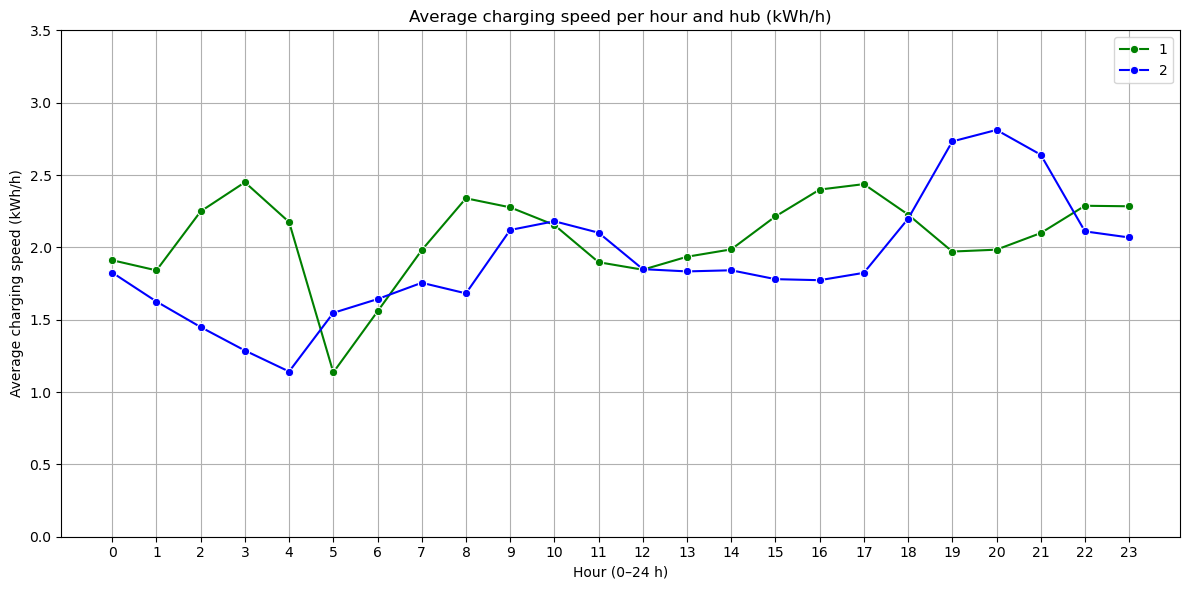

In [49]:
avg_charging_speed = []

for site in data_unique['siteID'].unique():
    hub_data = data_unique[data_unique['siteID'] == site]
    
    for _, session in hub_data.iterrows():
        connection_time = session['connectionTime']
        doneCharging_time = session['doneChargingTime']
        kwh_delivered = session['kWhDelivered']
        
        start_hour = connection_time.hour
        end_hour = doneCharging_time.hour
        
        if doneCharging_time < connection_time:
            doneCharging_time += pd.Timedelta(days=1)
        
        total_duration_hours = (doneCharging_time - connection_time).total_seconds() / 3600

        if total_duration_hours > 0:
            for hour in range(start_hour, end_hour + 1) if start_hour <= end_hour else list(range(start_hour, 24)) + list(range(0, end_hour + 1)):
                if hour == start_hour:
                    partial_duration = 1 - (connection_time.minute / 60)
                elif hour == end_hour:
                    partial_duration = doneCharging_time.minute / 60
                else:
                    partial_duration = 1
                
                energy_for_hour = kwh_delivered * (partial_duration / total_duration_hours)
                avg_charging_speed.append({'siteID': site, 'hour': hour, 'energyPerHour': energy_for_hour})

avg_charging_speed_df = pd.DataFrame(avg_charging_speed)

hourly_avg_speed = (
    avg_charging_speed_df.groupby(['siteID', 'hour'])['energyPerHour']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_avg_speed,
    x='hour',
    y='energyPerHour',
    hue='siteID',
    palette=colors,
    marker='o'
)
plt.title('Average charging speed per hour and hub (kWh/h)')
plt.xlabel('Hour (0–24 h)')
plt.ylabel('Average charging speed (kWh/h)')
plt.xticks(ticks=range(0, 24), labels=range(0, 24))
plt.ylim(0, 3.5)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=10, title_fontsize=12)
plt.show()